In [1]:
# Alberto Bejarano (2025)
# 03_openFDA_UMAP_v02
# pip install nbqa flake8
# nbqa flake8 openFDA_UMAP_v06.ipynb --select=F401

In [2]:
# These Jupyter notebooks process FDA adverse event data for a set of drugs. It first retrieves data using an API and extracts relevant details about the types of adverse events
# for each drug. The data is then aggregated, grouped by drug and event, and pivoted into a table format for further analysis. The notebook applies data scaling and dimensionality
# reduction techniques, such as Principal Component Analysis (PCA), to standardize and reduce the dimensionality of the dataset. It uses clustering (Leiden algorithm) to group 
# similar data points and explores the relationships between the drugs and their adverse events. Finally, the notebook visualizes the results using UMAP, providing insights into 
# the patterns and associations between the drugs and the severity of their associated adverse events.

In [3]:
# 03_openFDA_UMAP_v02
# This JupyterLab cell processes and visualizes FDA adverse event data for drugs by applying dimensionality reduction and clustering techniques. It first merges two datasets—one for
# standard-of-care drugs and one for experimental drugs—then pivots the data to create a matrix of adverse event severities. Using Scanpy, the data is standardized and reduced via PCA,
# followed by Leiden clustering to group drugs with similar adverse event profiles.  Data is transformed into a numerical matrix and processed using PCA and Leiden clustering.
# UMAP is applied for dimensionality reduction and visualization. Multiple UMAP parameter combinations are explored, and final plots are generated, coloring points by drug name, 
# data source, and cluster assignment to uncover patterns and relationships among drug safety profiles.

In [4]:
import os   # Record the name of the active Conda environment
env_name = os.getenv('CONDA_DEFAULT_ENV'); print(f"Active Conda environment: {env_name}")
!conda env export > {env_name}.yml

Active Conda environment: jupyterlab


In [5]:
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

April 21, 2025 19:06:41


In [6]:
import warnings
from anndata._core.aligned_df import ImplicitModificationWarning
warnings.simplefilter("ignore", ImplicitModificationWarning)

In [7]:
import requests, time, matplotlib, contextlib, os
from IPython.display import Audio, display
#         .         .         .         .         .         .         .         .
from matplotlib.patches import Patch
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns  = 200

In [8]:
import scanpy as sc; sc.settings.seed = 42

In [9]:
resolution   = 1         # Running PCA and Leiden
n_iterations = 5

In [10]:
SoC_AEs_df = pd.read_csv("./data/standard_of_care.csv")
SoC_AEs_df.sample(5)

,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total
104099,Kadcyla,Pituitary Tumour Benign,0,0,0,1,1,0.00,0.00,0.00,0.00,0.00
7687,Dabrafenib,Body Temperature Increased,18,20,19,22,79,0.14,0.13,0.16,0.14,0.14
42008,Sorafenib,Granulocytopenia,2,2,2,2,8,0.01,0.01,0.02,0.01,0.01
14001,5-Fu,Suicide Attempt,0,22,8,10,40,0.00,0.13,0.29,0.05,0.09
79077,5-Fu,Haemorrhagic Erosive Gastritis,0,2,0,0,2,0.00,0.01,0.00,0.00,0.00


In [11]:
drug_AEs_df = pd.read_csv("./data/drug_AEs.csv")
drug_AEs_df.sample(5)

,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total
5226,Adcetris,Embolic Cerebral Infarction,1,1,1,1,4,0.01,0.01,0.01,0.01,0.01
3446,Kadcyla,Product Barcode Issue,2,2,2,2,8,0.01,0.01,0.01,0.01,0.01
4535,Trodelvy,Intra-Abdominal Haemorrhage,2,1,2,1,6,0.03,0.02,0.03,0.02,0.02
5404,Adcetris,Culture Positive,1,1,0,1,3,0.01,0.01,0.00,0.01,0.01
6685,Kadcyla,Foetal Growth Restriction,0,0,0,1,1,0.00,0.00,0.00,0.00,0.00


In [12]:
drug_AEs_df["data_source"] = "drug_AEs"
SoC_AEs_df["data_source"]  = "SoC_AEs"

In [13]:
df_concat = pd.concat([SoC_AEs_df, drug_AEs_df], ignore_index=True)

In [14]:
df_concat_2 = df_concat[['data_source', 'Drug_Name', 'Adverse_Event', '%Death', '%Hospitalization']]
df_concat_2.head(3)

,data_source,Drug_Name,Adverse_Event,%Death,%Hospitalization
0,SoC_AEs,Pertuzumab,Diarrhoea,4.06,4.05
1,SoC_AEs,Pertuzumab,Off Label Use,3.82,3.55
2,SoC_AEs,Palbociclib,Neutropenia,3.55,3.39


In [15]:
pivot_df = df_concat_2.pivot_table(index=['data_source', 'Drug_Name'], columns='Adverse_Event', values='%Death', aggfunc='sum', fill_value=0)
pivot_df = pivot_df.reset_index()
pivot_df.index.name = None
pivot_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_df.columns]
print(len(pivot_df)); pivot_df.head(3)

53


,data_source,Drug_Name,5-Hydroxyindolacetic Acid In Urine,5-Hydroxyindolacetic Acid Increased,5Q Minus Syndrome,Abasia,Abdomen Crushing,Abdominal Abscess,Abdominal Adhesions,Abdominal Bruit,Abdominal Cavity Drainage,Abdominal Compartment Syndrome,Abdominal Discomfort,Abdominal Distension,Abdominal Fat Apron,Abdominal Hernia,Abdominal Hernia Perforation,Abdominal Hernia Repair,Abdominal Incarcerated Hernia,Abdominal Infection,Abdominal Injury,Abdominal Lymphadenopathy,Abdominal Mass,Abdominal Neoplasm,Abdominal Operation,Abdominal Pain,Abdominal Pain Lower,Abdominal Pain Upper,Abdominal Rebound Tenderness,Abdominal Rigidity,Abdominal Sepsis,Abdominal Strangulated Hernia,Abdominal Symptom,Abdominal Tenderness,Abdominal Wall Abscess,Abdominal Wall Cyst,Abdominal Wall Disorder,Abdominal Wall Haematoma,Abdominal Wall Haemorrhage,Abdominal Wall Infection,Abdominal Wall Mass,Abdominal Wall Neoplasm Malignant,Abdominal Wall Oedema,Abdominal Wall Pain,Abdominal Wall Sinus,Abdominal Wall Wound,Abdominal Wound Dehiscence,Aberrant Aortic Arch,Abnormal Behaviour,Abnormal Clotting Factor,Abnormal Dreams,Abnormal Faeces,Abnormal Labour,Abnormal Loss Of Weight,Abnormal Menstrual Clots,Abnormal Sensation In Eye,Abnormal Sleep-Related Event,Abnormal Uterine Bleeding,Abnormal Weight Gain,Abnormal Withdrawal Bleeding,Abortion,Abortion Incomplete,Abortion Induced,Abortion Induced Complete,Abortion Missed,Abortion Spontaneous,Abortion Spontaneous Incomplete,Abscess,Abscess Bacterial,Abscess Drainage,Abscess Fungal,Abscess Intestinal,Abscess Jaw,Abscess Limb,Abscess Neck,Abscess Oral,Abscess Rupture,Abscess Soft Tissue,Abscess Sterile,Absent Bowel Movement,Abulia,Acalculia,Acanthamoeba Infection,Acantholysis,Acanthosis,Acanthosis Nigricans,Acarodermatitis,Accelerated Hypertension,Accelerated Idioventricular Rhythm,Accessory Spleen,Accident,Accident At Home,Accident At Work,Accidental Death,Accidental Exposure To Product,Accidental Exposure To Product By Child,Accidental Exposure To Product Packaging,Accidental Exposure To Product Packaging By Child,Accidental Overdose,Accidental Poisoning,...,Vulvovaginal Pruritus,Vulvovaginal Rash,Vulvovaginal Swelling,Vulvovaginitis,Waist Circumference Decreased,Waist Circumference Increased,Waldenstrom^S Macroglobulinaemia,Walking Aid User,Walking Disability,Walking Distance Test Abnormal,Wall Motion Score Index Abnormal,Walled-Off Pancreatic Necrosis,Wallerian Degeneration,Warm Type Haemolytic Anaemia,Water Intoxication,Weaning Failure,Weight Abnormal,Weight Bearing Difficulty,Weight Control,Weight Decreased,Weight Fluctuation,Weight Gain Poor,Weight Increased,Weight Loss Poor,Welander Distal Myopathy,Werner^S Syndrome,Wernicke^S Encephalopathy,West Nile Viral Infection,West Nile Virus Test Positive,Wheelchair User,Wheezing,White Blood Cell Analysis Abnormal,White Blood Cell Analysis Decreased,White Blood Cell Count,White Blood Cell Count Abnormal,White Blood Cell Count Decreased,White Blood Cell Count Increased,White Blood Cell Disorder,White Blood Cells Urine,White Blood Cells Urine Positive,White Coat Hypertension,White Matter Lesion,Wisdom Teeth Removal,Withdrawal Hypertension,Withdrawal Of Life Support,Withdrawal Syndrome,Wolff-Parkinson-White Syndrome,Wound,Wound Abscess,Wound Complication,Wound Decomposition,Wound Dehiscence,Wound Drainage,Wound Evisceration,Wound Haematoma,Wound Haemorrhage,Wound Infection,Wound Infection Bacterial,Wound Infection Fungal,Wound Infection Pseudomonas,Wound Infection Staphylococcal,Wound Necrosis,Wound Secretion,Wound Sepsis,Wound Treatment,Wrist Deformity,Wrist Fracture,Wrist Surgery,Wrong Device Used,Wrong Dosage Form,Wrong Dosage Formulation,Wrong Dose,Wrong Drug Administered,Wrong Patient,Wrong Patient Received Medication,Wrong Patient Received Product,Wrong Product Administered,Wrong Schedule,Wrong Strength,Wrong Technique In Device Usage Process,Wrong Technique In Drug Usage Process,Wrong Technique In Product Usage Process,X-Linked Chromosomal Disorder,X-Ray,X-Ray Abn

In [16]:
# Drop 'Drug_Name' for scaling and keep it for later
drug_names = pivot_df[['data_source', 'Drug_Name']]
drug_names.sample(3)

,data_source,Drug_Name
26,SoC_AEs,Lenvatinib
44,SoC_AEs,Trametinib
41,SoC_AEs,T-Dm1


In [17]:
pivot_df2 = pivot_df.drop(columns=['data_source', 'Drug_Name'])
print(len(pivot_df2)); pivot_df2.head(3)

53


,5-Hydroxyindolacetic Acid In Urine,5-Hydroxyindolacetic Acid Increased,5Q Minus Syndrome,Abasia,Abdomen Crushing,Abdominal Abscess,Abdominal Adhesions,Abdominal Bruit,Abdominal Cavity Drainage,Abdominal Compartment Syndrome,Abdominal Discomfort,Abdominal Distension,Abdominal Fat Apron,Abdominal Hernia,Abdominal Hernia Perforation,Abdominal Hernia Repair,Abdominal Incarcerated Hernia,Abdominal Infection,Abdominal Injury,Abdominal Lymphadenopathy,Abdominal Mass,Abdominal Neoplasm,Abdominal Operation,Abdominal Pain,Abdominal Pain Lower,Abdominal Pain Upper,Abdominal Rebound Tenderness,Abdominal Rigidity,Abdominal Sepsis,Abdominal Strangulated Hernia,Abdominal Symptom,Abdominal Tenderness,Abdominal Wall Abscess,Abdominal Wall Cyst,Abdominal Wall Disorder,Abdominal Wall Haematoma,Abdominal Wall Haemorrhage,Abdominal Wall Infection,Abdominal Wall Mass,Abdominal Wall Neoplasm Malignant,Abdominal Wall Oedema,Abdominal Wall Pain,Abdominal Wall Sinus,Abdominal Wall Wound,Abdominal Wound Dehiscence,Aberrant Aortic Arch,Abnormal Behaviour,Abnormal Clotting Factor,Abnormal Dreams,Abnormal Faeces,Abnormal Labour,Abnormal Loss Of Weight,Abnormal Menstrual Clots,Abnormal Sensation In Eye,Abnormal Sleep-Related Event,Abnormal Uterine Bleeding,Abnormal Weight Gain,Abnormal Withdrawal Bleeding,Abortion,Abortion Incomplete,Abortion Induced,Abortion Induced Complete,Abortion Missed,Abortion Spontaneous,Abortion Spontaneous Incomplete,Abscess,Abscess Bacterial,Abscess Drainage,Abscess Fungal,Abscess Intestinal,Abscess Jaw,Abscess Limb,Abscess Neck,Abscess Oral,Abscess Rupture,Abscess Soft Tissue,Abscess Sterile,Absent Bowel Movement,Abulia,Acalculia,Acanthamoeba Infection,Acantholysis,Acanthosis,Acanthosis Nigricans,Acarodermatitis,Accelerated Hypertension,Accelerated Idioventricular Rhythm,Accessory Spleen,Accident,Accident At Home,Accident At Work,Accidental Death,Accidental Exposure To Product,Accidental Exposure To Product By Child,Accidental Exposure To Product Packaging,Accidental Exposure To Product Packaging By Child,Accidental Overdose,Accidental Poisoning,Accidental Underdose,Accommodation Disorder,...,Vulvovaginal Pruritus,Vulvovaginal Rash,Vulvovaginal Swelling,Vulvovaginitis,Waist Circumference Decreased,Waist Circumference Increased,Waldenstrom^S Macroglobulinaemia,Walking Aid User,Walking Disability,Walking Distance Test Abnormal,Wall Motion Score Index Abnormal,Walled-Off Pancreatic Necrosis,Wallerian Degeneration,Warm Type Haemolytic Anaemia,Water Intoxication,Weaning Failure,Weight Abnormal,Weight Bearing Difficulty,Weight Control,Weight Decreased,Weight Fluctuation,Weight Gain Poor,Weight Increased,Weight Loss Poor,Welander Distal Myopathy,Werner^S Syndrome,Wernicke^S Encephalopathy,West Nile Viral Infection,West Nile Virus Test Positive,Wheelchair User,Wheezing,White Blood Cell Analysis Abnormal,White Blood Cell Analysis Decreased,White Blood Cell Count,White Blood Cell Count Abnormal,White Blood Cell Count Decreased,White Blood Cell Count Increased,White Blood Cell Disorder,White Blood Cells Urine,White Blood Cells Urine Positive,White Coat Hypertension,White Matter Lesion,Wisdom Teeth Removal,Withdrawal Hypertension,Withdrawal Of Life Support,Withdrawal Syndrome,Wolff-Parkinson-White Syndrome,Wound,Wound Abscess,Wound Complication,Wound Decomposition,Wound Dehiscence,Wound Drainage,Wound Evisceration,Wound Haematoma,Wound Haemorrhage,Wound Infection,Wound Infection Bacterial,Wound Infection Fungal,Wound Infection Pseudomonas,Wound Infection Staphylococcal,Wound Necrosis,Wound Secretion,Wound Sepsis,Wound Treatment,Wrist Deformity,Wrist Fracture,Wrist Surgery,Wrong Device Used,Wrong Dosage Form,Wrong Dosage Formulation,Wrong Dose,Wrong Drug Administered,Wrong Patient,Wrong Patient Received Medication,Wrong Patient Received Product,Wrong Product Administered,Wrong Schedule,Wrong Strength,Wrong Technique In Device Usage Process,Wrong Technique In Drug Usage Process,Wrong Technique In Product Usage Process,X-Linked Chromosomal Di

In [18]:
# Keep a numeric-only version
df_numeric       = pivot_df2.select_dtypes(include='number').copy()
df_numeric       = df_numeric.apply(pd.to_numeric, errors='coerce', downcast='float')
pivot_df.index   = pivot_df2.index.astype(str)
df_numeric.index = df_numeric.index.astype(str)
print(df_numeric.shape); print(df_numeric.max().max())

(53, 11286)
14.069296836853027


In [19]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        from anndata._core.aligned_df import ImplicitModificationWarning
        warnings.simplefilter("ignore", ImplicitModificationWarning)

        df_numeric = pivot_df2.select_dtypes(include='number').copy()     # Flatten MultiIndex if present and reset index
        if isinstance(df_numeric.index, pd.MultiIndex):
            df_numeric = df_numeric.reset_index(drop=True)

        pivot_df = pivot_df.reset_index(drop=True)                        # Reset index on pivot_df to ensure alignment

        adata_temp = sc.AnnData(df_numeric)                               # Create AnnData object
        adata_temp.obs['Drug_Name']   = pivot_df['Drug_Name'].values
        adata_temp.obs['data_source'] = pivot_df['data_source'].values
        
        sc.pp.pca(adata_temp); sc.pp.neighbors(adata_temp)
        sc.tl.leiden(adata_temp, resolution=resolution, key_added = "Leiden", flavor="igraph", n_iterations=n_iterations, directed=False)

CPU times: total: 16.7 s
Wall time: 15 s


In [20]:
# Ensure that 'Drug_Name' is correctly mapped to categorical values (for discrete colors)
adata_temp.obs['Drug_Name']   = adata_temp.obs['Drug_Name'].astype('category')
adata_temp.obs['data_source'] = adata_temp.obs['data_source'].astype('category')

In [21]:
# Define UMAP parameters for exploration
MIN_DISTS = [0.1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7]  # Adjusted values for min_dist
SPREADS   = [0.1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7]  # Adjusted values for spread

In [22]:
%%time
'''
fig, axes = plt.subplots(len(MIN_DISTS), len(SPREADS), figsize=(12, 12))    # Create a figure for UMAP plots (subplots)
#          .         .          .          .          .         .          .          .          .         .          .          .
# Loop through all combinations of MIN_DIST and SPREAD
for (i, min_dist), (j, spread) in tqdm(product(enumerate(MIN_DISTS), enumerate(SPREADS)), total=len(MIN_DISTS) * len(SPREADS)):
    
    ax = axes[i][j]                                          # Get the subplot axis

    with warnings.catch_warnings():                          # Recompute UMAP with new parameters, suppressing warnings/output
        warnings.simplefilter("ignore")
        with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)
    
    cmap = matplotlib.colormaps.get_cmap('tab20')             # Plot UMAP with discrete coloring
    kws = {'s': 50, 'add_outline': True, 'outline_width': (0.2, 0.01), 'outline_color': ('#545955', 'white')}
    sc.pl.umap(adata_temp, title='', color='Drug_Name', cmap=cmap, legend_loc='right margin', show=False, sort_order=False, **kws, ax=ax)

    if i == 0:                                                # Set title only for the top row
        ax.set_title(f"spread \n {spread}", fontsize=8)
    else:
        ax.set_title("")                                      # Clear title if not top row

    if j == 0:                                                # Set ylabel only for the first column
        ax.set_ylabel(f"min_dist \n {min_dist}", fontsize=8, rotation=90, labelpad=5)
    else:
        ax.set_ylabel("")                                     # Remove ylabel for other columns
        
    ax.set_xlabel("")
    ax.spines['top'].set_visible(False);   ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray');   ax.spines['bottom'].set_color('gray')
    
#          .         .          .          .          .         .          .          .          .         .          .          .
fig_legend, ax_legend = plt.subplots(figsize=(4, 6))          # Create an empty plot and copy the legend from the UMAP plot


handles, labels = axes[-1][-1].get_legend_handles_labels()    # Get the legend from the last UMAP plot (e.g., the last subplot)

for ax in axes.flatten():                                     # Remove the legend from the original UMAP plot
    ax.legend_.remove()

# Plot the copied legend on the empty plot
ax_legend.legend(handles, labels, loc='center')               # Plot the copied legend on the empty plot
ax_legend.axis('off')                                         # Remove axes for a clean legend-only plot
#          .         .          .          .          .         .          .          .          .         .          .          .
fig_legend.tight_layout()                                     # Save the legend-only plot
#fig_legend.savefig("UMAP_Legend_Only.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# Adjust layout and save the UMAP figure again without the legend
#plt.tight_layout(rect=[0.01, 0.01, 0.01, 0.01])              # Leave space for Y-axis labels
#plt.savefig("UMAP_Exploration_Discrete_Colors_No_Legend.png", format="png", bbox_inches="tight", dpi=300)
plt.show(); plt.close()
#''';

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
# Set your chosen parameters
min_dist = 1E3     # Example, replace with your final choice
spread   = 1E2     # Example, replace with your final choice

with warnings.catch_warnings():    # Recompute UMAP with final parameters
    warnings.simplefilter("ignore")
    with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)

In [24]:
# Get UMAP coordinates and labels
umap_coords  = adata_temp.obsm["X_umap"]
drug_names   = adata_temp.obs["Drug_Name"]
data_sources = adata_temp.obs["data_source"]
leiden_clust = adata_temp.obs["Leiden"]

In [25]:
# Plot scatter manually
cmap         = matplotlib.colormaps.get_cmap('tab20')
unique_drugs = drug_names.unique()
color_dict   = {name: cmap(i % cmap.N) for i, name in enumerate(unique_drugs)}
colors       = [color_dict[name] for name in drug_names]

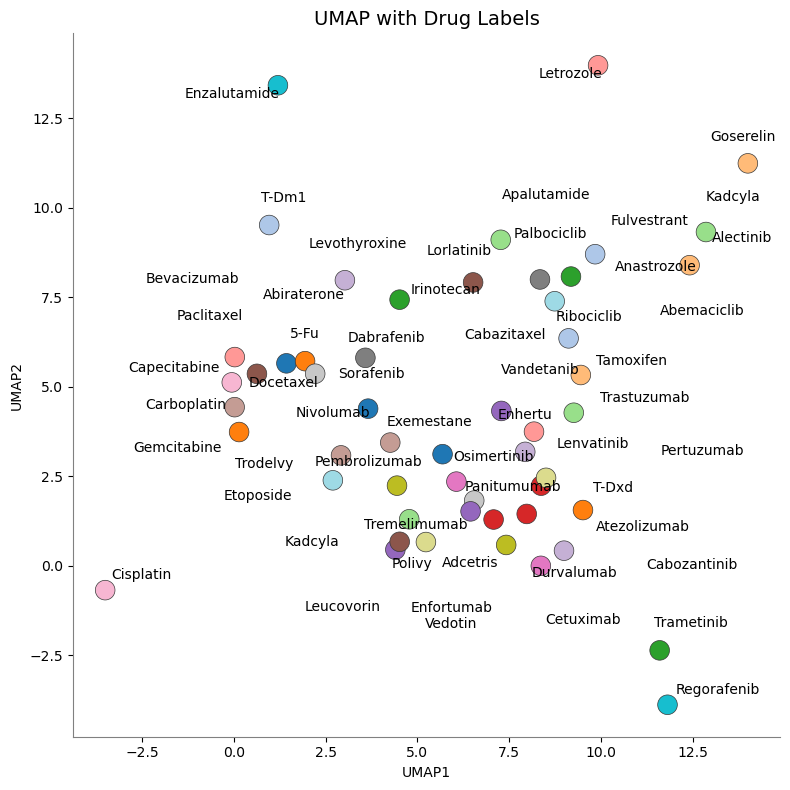

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))  # Big plot

ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=colors, s=200, edgecolor='#383838', linewidth=0.5, zorder=2)

texts = [] # Add text labels
for x, y, label in zip(umap_coords[:, 0], umap_coords[:, 1], drug_names):
    label_split = label.split(' ')
    label_top = label_split[0]
    label_bottom = ' '.join(label_split[1:])
    text = ax.text(x - 0.01, y + 0.01, f"{label_top}\n{label_bottom}", fontsize=10, ha='center', va='center', zorder=3)
    texts.append(text)

# Adjust text to avoid overlap (no arrows)
adjust_text(texts, ax=ax, expand=(1.05, 1.05))

# Remove axes labels and customize spines
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_title("UMAP with Drug Labels", fontsize=14)

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

plt.tight_layout()
#plt.savefig("./plots/UMAPwithDrugLabels.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [27]:
# Plot scatter manually
cmap               = matplotlib.colormaps.get_cmap('tab20')
unique_data_source = data_sources.unique()
color_dict         = {name: cmap(i % cmap.N) for i, name in enumerate(unique_data_source)}
colors             = [color_dict[name] for name in data_sources]

In [28]:
color_dict = {
    'drug_AEs':    '#ff7f0e',    # blue
    'SoC_AEs':     '#1f77b4',    # orange
    #'VigiBase':   '#2ca02c',    # green
    #'JP-PMDA':    '#d62728',    # red
    # Add more manually as needed
}

colors = [color_dict[src] for src in data_sources]   # Assign colors to each row based on data_source

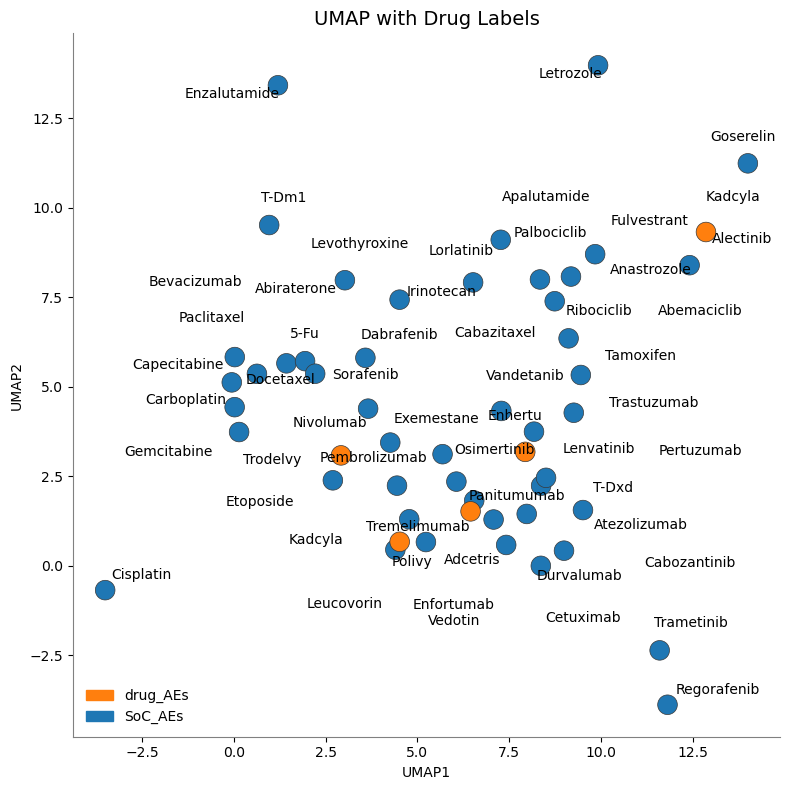

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))  # Big plot

ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=colors, s=200, edgecolor='#383838', linewidth=0.5, zorder=2)

texts = [] # Add text labels
for x, y, label in zip(umap_coords[:, 0], umap_coords[:, 1], drug_names):
    label_split = label.split(' ')
    label_top = label_split[0]
    label_bottom = ' '.join(label_split[1:])
    text = ax.text(x - 0.01, y + 0.01, f"{label_top}\n{label_bottom}", fontsize=10, ha='center', va='center', zorder=3)
    texts.append(text)

# Adjust text to avoid overlap (no arrows)
adjust_text(texts, ax=ax, expand=(1.05, 1.05))

# Remove axes labels and customize spines
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_title("UMAP with Drug Labels", fontsize=14)

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

legend_handles = [Patch(color=color, label=label) for label, color in color_dict.items()]
ax.legend(handles=legend_handles, title='', loc='lower left', bbox_to_anchor=(0, 0), frameon=False)

plt.tight_layout()
#plt.savefig("./plots/UMAPwithDrugLabels.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [30]:
cmap_leiden   = matplotlib.colormaps.get_cmap('tab20')
unique_leiden = leiden_clust.unique()
color_dict_leiden = {name: cmap_leiden(i % cmap_leiden.N) for i, name in enumerate(unique_leiden)}
colors_leiden = [color_dict_leiden[name] for name in leiden_clust]

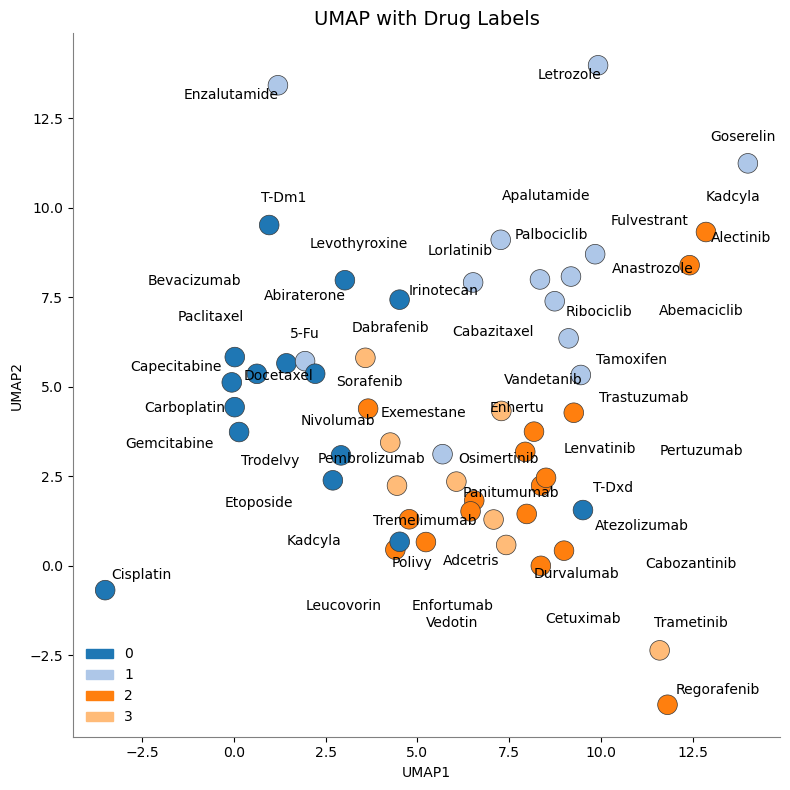

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))  # Big plot

ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=colors_leiden, s=200, edgecolor='#383838', linewidth=0.5, zorder=2)

texts = [] # Add text labels
for x, y, label in zip(umap_coords[:, 0], umap_coords[:, 1], drug_names):
    label_split = label.split(' ')
    label_top = label_split[0]
    label_bottom = ' '.join(label_split[1:])
    text = ax.text(x - 0.01, y + 0.01, f"{label_top}\n{label_bottom}", fontsize=10, ha='center', va='center', zorder=3)
    texts.append(text)

# Adjust text to avoid overlap (no arrows)
adjust_text(texts, ax=ax, expand=(1.05, 1.05))

# Remove axes labels and customize spines
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_title("UMAP with Drug Labels", fontsize=14)

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

legend_handles = [Patch(color=color, label=label) for label, color in color_dict_leiden.items()]
ax.legend(handles=legend_handles, title='', loc='lower left', bbox_to_anchor=(0, 0), frameon=False)

plt.tight_layout()
#plt.savefig("./plots/UMAPwithDrugLabels.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [32]:
adata_temp

AnnData object with n_obs × n_vars = 53 × 11286
    obs: 'Drug_Name', 'data_source', 'Leiden'
    uns: 'pca', 'neighbors', 'Leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
df = adata_temp.obs[['Drug_Name', 'data_source', 'Leiden']].copy()
df[['UMAP1', 'UMAP2']] = adata_temp.obsm['X_umap']
df.head()

,Drug_Name,data_source,Leiden,UMAP1,UMAP2
0,5-Fu,SoC_AEs,0,1.43,5.65
1,Abemaciclib,SoC_AEs,1,9.11,6.35
2,Abiraterone,SoC_AEs,1,1.94,5.71
3,Alectinib,SoC_AEs,2,12.41,8.39
4,Anastrozole,SoC_AEs,1,9.18,8.07


In [34]:
leiden_list = df['Leiden'].unique().tolist(); print(leiden_list)

['0', '1', '2', '3']


In [35]:
# Path to your audio file
audio_file = "./data/clock-chime-88027.mp3"
display(Audio(audio_file, autoplay=True))

In [36]:
elapsed_time = time.time() - start
minutes, seconds = divmod(elapsed_time, 60)
print("'03_openFDA_UMAP_v02' script run time:", f"{int(minutes)} min {int(seconds)} sec.")

'03_openFDA_UMAP_v02' script run time: 0 min 35 sec.
